# 学習に関するテクニック

[最適化（optimization）](http://www.orsj.or.jp/archive2/or60-4/or60_4_191.pdf)はニューラルネットワークの課題。損失関数（loss function）の値を小さくするようにパラメータを調整すること。過学習・勾配消失・爆発（発散）を防ぐ手法を学ぶことが学習に関するテクニックである。一般的には以下のよな手法が知られている。

- パラメータの更新方法を変更する
- 活性化関数を変更する
- ネットワークの重みの初期値を調整する
- 学習係数を下げる
- ネットワークの自由度を制約する（Dropoutなど）

しかし、近年においては

- Batch Normalizationを挿入する
- ハイパーパラメータを探索する

という手法が主流になっている。

## 勾配更新アルゴリズムの選定による最適化
基本的には、勾配消失・爆発を防ぐための手法であり、これまでは

活性化関数を変更する（ReLUなど）
ネットワークの重みの初期値を事前学習する
学習係数を下げる
ネットワークの自由度を制約する（Dropoutなど）


### 勾配降下法

微分の傾きを収束させることを目指す方法。  

### バッチ勾配降下法

ミニバッチ処理により、全てのデータ／テストを一括で順番に計算し勾配を求める。確実だが、リソースの問題がある。

### 確率的勾配降下法

全てのデータを一括で処理せず、データをある確率分布に基づいて無作為全抽出し勾配を求める。
優良なデータを先に処理することが出来る可能性がある。

### ミニバッチ勾配降下法

全てのデータを一括で処理せず、データをある確率分布に基づいて無作為標本抽出し勾配を求める。
サンプリングレート（バッチサイズ）とサンプリング分布（基本的にランダムサンプリングとなる）により
優良な標本データを先に処理し目的関数に近づける事ができる。
現在の機械学習においては基本的にこの手法が推奨される。

### 勾配更新アルゴリズムによる収束までの違い

http://ruder.io/optimizing-gradient-descent/  
https://keras.io/optimizers/

![](http://sebastianruder.com/content/images/2016/01/saddle_point_evaluation_optimizers.gif)

### 様々な勾配降下法の最適化アルゴリズム

#### SGD(Stochastic Gradient Descent, 確率的勾配降下法)

$W \leftarrow W - \eta \frac{\partial L}{\partial W}$  
$0 \lt \eta \lt 1$  
$W::Weight\ \ \eta::Learning\ Rate\ \ L::Loss\ Function\ \ \partial::Partial\ Differentiation$

単純な勾配降下法全てのベース(Vanilla)となる。全集合（学習データ集合、テストデータ集合）の中の一部(batch_size分)の集合をepoch回だけ__無作為サンプリング（サンプリング分布に注意）__し、勾配降下法の計算に反映する手法。大規模なデータを処理する際、少ない計算量で実装可能であり、非常にシンプルなのでMLアルゴリズムのデバッグが容易。__目的関数と一致しない集合で学習してしまうと急激に勾配が上下し目的関数もそれにつられて大きく変動する可能性がある__。

In [1]:
class SGD:
    """確率的勾配降下法（Stochastic Gradient Descent）"""
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

#### Momentam (Momentam SGD)

$v \leftarrow \alpha v - \eta \frac{\partial L}{\partial W}$  
$W \leftarrow W + v $  
$0 \lt \alpha \lt 1$  
$v::velocity\ \ \alpha::Air\ Resistance\ (aka. Friction)$

SGDにおいて勾配更新の際に勾配を直接計算に反映するのではなく「直前の勾配の加速度」変数を掛け算し続けることでSGDの勾配更新を滑らかにする方法。複雑な関数でなければSGDよりも早く収束する可能性がある。勾配と正方向の加速度が「勢い」であり、逆方向の加速度が物理学でいう「摩擦」や「空気抵抗」に近い。__加速度に定数$\alpha$を毎回掛け算しているのは、静止摩擦を付加し収束を期待する為である。__

In [8]:
class Momentum:
    """慣性SGD (Momentam SGD)"""
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

#### NAG (Nesterov's Accelerated Gradient) 

Momentamでは加速度を計算する際に勾配計算前の値を使用していたが、NAGでは勾配計算後の値を使用することで、勾配の変化に関してMomentamよりも一歩先で気づくことが出来るようになる。それ以外は特に変わらない。同盟で複数のアルゴリズムが存在する。

#### Adagrad

$h \leftarrow h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}$  
$W \leftarrow W - \eta \frac{1}{\sqrt{h}} \frac{\partial L}{\partial W}$  
$h::Rate\ of\ Learning\ Rate\ \ \odot::Hadamard\ Product$ (アダマール積::行列の要素ごとの単純乗算。内積でない。)

勾配更新の際に「学習率」自体を勾配で自乗したもので割る。これにより学習率そのものの指数関数的な減衰をもたらす。最初の勾配が大きいものが強く学習され、収束に従って緩やかに学習されるようになるので最初に大きく学習を進めることが出来る。最初に学習したデータが良好なデータであればあるほど効果的に働くが学習が進むに連れて学習率が0に近づく為、__オンライン学習（継続的学習）の場合は新鮮なデータを受け入れるのが難しくなる欠点がある__。アダマール積を使用しているのは、各種パラメータ（行・列）毎のデータ変動を一個ずつ対応して反映できるようにするためである。※$h$は最初は非常に小さな数値に設定し、ゼロ除算を回避すること。  

In [4]:
class AdaGrad:
    """AdaGrad (Adaptive subgradient methods for online learning and stochastic optimization)"""
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            #1e-7はゼロ除算を防ぐため

#### RMSprop

$h \leftarrow \alpha h + (1-\alpha)\frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}$  
$W \leftarrow W - \eta \frac{1}{\sqrt{h}} \frac{\partial L}{\partial W}$  
$0 \le \alpha \le 1$  
$\alpha::Rate\ of\ exponential\ moving\ average;EMA;$ 指数移動平均

Adagradにおいて学習が進むにつれて新鮮なデータを受入し難くなる欠点を克服するため、__一つ前の学習率に定数$\alpha$を掛けて減衰させ、受け入れる新鮮なデータの学習率の影響を強める__手法。hに関して指数移動平均を適用したものである。過去のデータの影響力の加重が指数関数的に減衰するので、$\alpha$の数値が低すぎた場合は過去のデータの影響力が直ちに低下してしまい、新鮮すぎる結果が発生し、数値が高すぎた場合は腐った結果が発生するリスクがある。

In [5]:
class RMSprop:
    """RMSprop"""
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#### AdaDelta

AdagradとRMSpropをあわせたもの。学習率が存在せず移動平均がそのまま学習率に反映される。

#### Adam

AdaGrad、RMSprop、AdaDeltaを合わせスケールを追加したもの

In [6]:
class Adam:
    """Adam (Adaptive moment estimation)"""
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

#### MNISTデータセットによる更新手法の比較

===========iteration:0===========
AdaGrad:2.073306458903855
SGD:2.523300165662966
Adam:2.121038352570406
Momentum:2.38792091140304
===========iteration:100===========
AdaGrad:0.2131088105273944
SGD:1.6044179080128664
Adam:0.3808571137285117
Momentum:0.3969831247395848
===========iteration:200===========
AdaGrad:0.13124025086807267
SGD:0.7830985515944628
Adam:0.22064014047211133
Momentum:0.3216731484452754
===========iteration:300===========
AdaGrad:0.06808923098744606
SGD:0.6325237467606476
Adam:0.16051907326110734
Momentum:0.23042036201574118
===========iteration:400===========
AdaGrad:0.06313508623562003
SGD:0.45209547106182657
Adam:0.13090639195898196
Momentum:0.16881274795022827
===========iteration:500===========
AdaGrad:0.0746353204854379
SGD:0.33067102745064325
Adam:0.12430283308476585
Momentum:0.17795406996349522
===========iteration:600===========
AdaGrad:0.041437727939144256
SGD:0.36918525431898697
Adam:0.127014809423026
Momentum:0.16947254478379217
===========iteration:700==

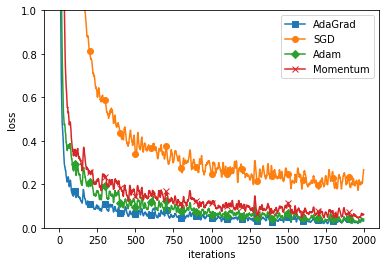

In [2]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


__留意__
* SGDは最初から最後まで学習に行き詰まっている
* Momentumは振れ幅が大きい
* Adamは最初の収束が早く振れ幅が少ない
* AdaGradが最初の方で効率よく学習しそのままキープできている

## 重みの初期値の調整による最適化

### 重みの初期値を0にするのはNG

これまではガウス分布（正規分布,np.random.randn）により生成される平均0標準偏差1のランダム分布から得られる重みを0.01倍して重みに割り当てていた。  それを例えばW = np.zeros_like(W)してしまうというのはバッドプラクティスである。  
__ニューラルネットワークにおいて重みの初期値を各要素毎に均一に設定してしまうと誤差逆伝搬方で各層が均一の値で更新されてしまい__、層と層の間の計算に意味が無くなってしまうためである。

### 隠れ層のアクティベーション分布から重みの初期値の最適な標準偏差を探る

隠れ層のアクティベーション（活性化関数適用後の出力データ）の分布を観察することで、ニューラルネットワークのパラメータの調整に関して有効な手立てを考えることができる。重みの初期値を調整しアクティベーション分布に偏りなくさせてニューラルネットワークの「表現の制限」と「勾配消失（Gradient Vanishing）」を避けることが目標。

### 重みの初期値（Sigmoid関数をアクティベーション関数にした場合）

標準偏差1の正規分布： w = np.random.randn(node_num, node_num) * 1


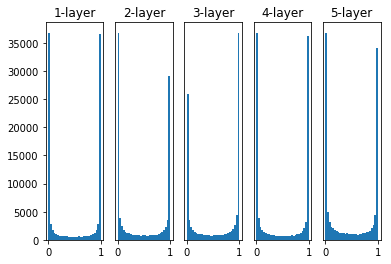

標準偏差0.01の正規分布： w = np.random.randn(node_num, node_num) * 0.01


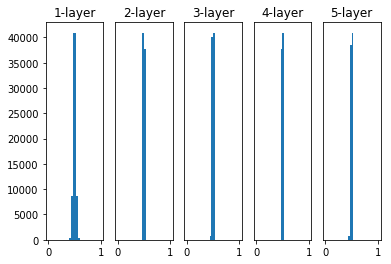

Xavierの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)


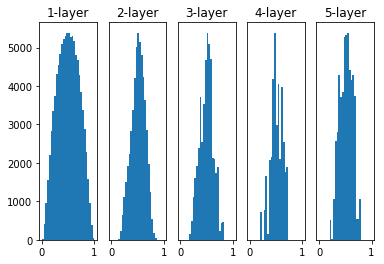

Heの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


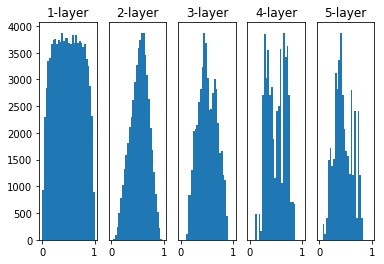

In [14]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data
print("標準偏差1の正規分布： w = np.random.randn(node_num, node_num) * 1")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("標準偏差0.01の正規分布： w = np.random.randn(node_num, node_num) * 0.01")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("Xavierの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("Heの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


### 重みの初期値（ReLU関数をアクティベーション関数にした場合）

標準偏差1の正規分布： w = np.random.randn(node_num, node_num) * 1


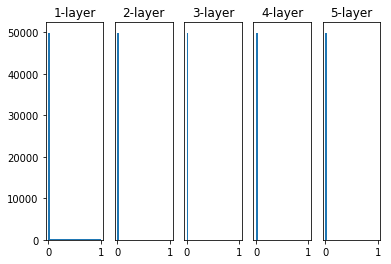

標準偏差0.01の正規分布： w = np.random.randn(node_num, node_num) * 0.01


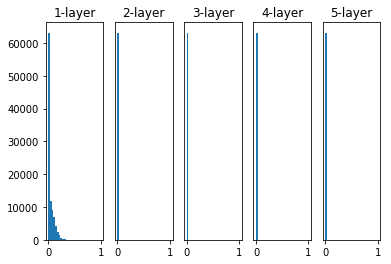

Xavierの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)


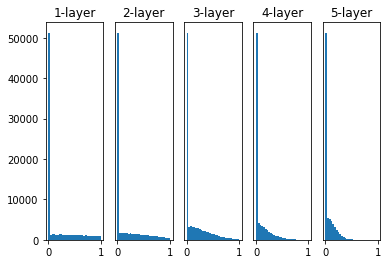

Heの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


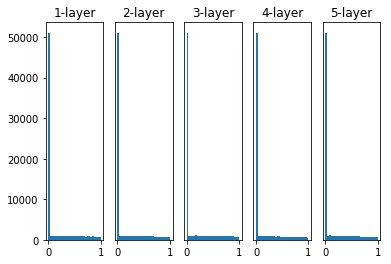

In [15]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data
print("標準偏差1の正規分布： w = np.random.randn(node_num, node_num) * 1")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("標準偏差0.01の正規分布： w = np.random.randn(node_num, node_num) * 0.01")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("Xavierの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("Heの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


### 重みの初期値（tanh関数をアクティベーション関数にした場合）

標準偏差1の正規分布： w = np.random.randn(node_num, node_num) * 1


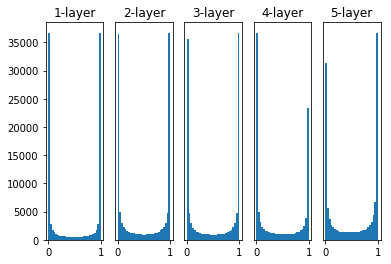

標準偏差0.01の正規分布： w = np.random.randn(node_num, node_num) * 0.01


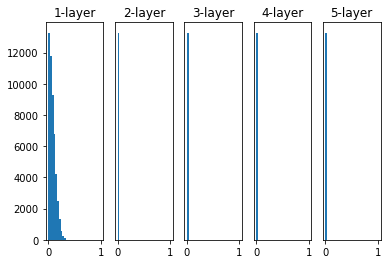

Xavierの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)


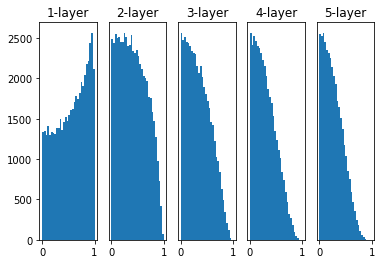

Heの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


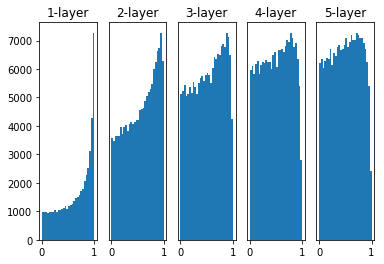

In [16]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data
print("標準偏差1の正規分布： w = np.random.randn(node_num, node_num) * 1")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    #z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("標準偏差0.01の正規分布： w = np.random.randn(node_num, node_num) * 0.01")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    #z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("Xavierの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    #z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("Heの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    #z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


### ベストプラクティス：アクティベーション関数がReLU関数ならHeの初期値を、アクティベーション関数がSigmoid関数ならXavierの初期値を、アクティベーション関数がtanh関数なら・・・？

#### ReLU関数をアクティベーション関数として持ったMNISTニューラルネットワークに対するの重み初期値分布による誤差比較

===========iteration:0===========
std=0.01:2.3025047128640304
Xavier:2.313383374896556
He:2.352801464350353
===========iteration:100===========
std=0.01:2.30188197530518
Xavier:2.2583643765094026
He:1.6330238543552074
===========iteration:200===========
std=0.01:2.30225644165031
Xavier:2.127229207938062
He:0.8634702094812619
===========iteration:300===========
std=0.01:2.301582259289641
Xavier:1.8551789364382827
He:0.5666139899888614
===========iteration:400===========
std=0.01:2.301262224991351
Xavier:1.448088413431125
He:0.5453957233261428
===========iteration:500===========
std=0.01:2.304384023598031
Xavier:0.9737266777861089
He:0.45937795981259955
===========iteration:600===========
std=0.01:2.301924097038047
Xavier:0.6974414715127122
He:0.40279157119477155
===========iteration:700===========
std=0.01:2.3049056291970613
Xavier:0.6206533838797386
He:0.3511152901133047
===========iteration:800===========
std=0.01:2.3021688467700567
Xavier:0.5277811176619274
He:0.31619016329750155
===

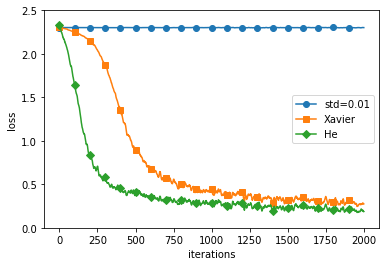

In [28]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

先述の通り、Heの初期値で学習が上手くいっている（誤差が減衰していっている）ことを確認する。これは
```python
networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
```
がReLU関数をアクティベーション関数としてもっているからである。今回は5層 x100個のニューロンのニューラルネットワークでMNISTの手書き文字を学習する際のケースである。

__アクティバーション関数によって発火されるニューロンの分布が偏った場合は学習以前の問題であり、もし偏りにより発火しなかった／発火の度合いが極端に低いニューロンにより引き起こされる学習が滞ってしまう。（学習の結果ニューロンの発火が起こらないのではなく、学習パラメータの設定が偏った結果発火が起こらないというのは正当なアクティベーションとは呼ばない）__

## Batch Normalization

先述では各層での「発火分布の正規化」をすることで学習の偏りを無くすということをしたがBatch Normalizationでは「各層の中の、ミニバッチ処理の中での発火分布の正規化」をすることで学習の方よりを無くす。以下のメリットがある。  
- 学習を速く進行させることが出来る（学習係数を大きくすることが出来る）
- 初期値にそれほど依存しない
- 過学習を抑制する（Dropoutなどの必要性を減らす）
  


### Batch Normalization とは

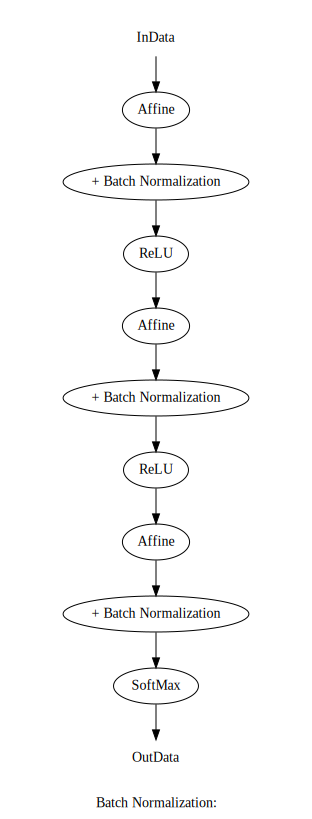

In [25]:
from graphviz import Digraph
dot = Digraph(comment="Batch Normalization: バッチ毎に正規化処理を行う")
dot.attr(rankdir="UD")
#dot.attr(ranksep="1.2")
dot.attr(nodesep=".05")
#dot.attr(margin="1")
#dot.attr(splines="polyline") #line or curved or ortho or polyline;
dot.attr(fixedsize="true")
dot.attr(label="Batch Normalization: バッチ毎に正規化処理を行う")
with dot.subgraph(name="main") as main:
    with main.subgraph(name="cluster_L1") as L1:
        L1.attr(label="")
        L1.attr(color="white")
        L1.node("main.L1N1", "InData", color="white")
    with main.subgraph(name="cluster_L2") as L2:
        L2.attr(label="")
        L2.attr(color="white")
        L2.node("main.L2N1","Affine")
    with main.subgraph(name="cluster_L3") as L3:
        L3.attr(label="")
        L3.attr(color="white")
        L3.node("main.L3N1", "+ Batch Normalization")
    with main.subgraph(name="cluster_L4") as L4:
        L4.attr(label="")
        L4.attr(color="white")
        L4.node("main.L4N1", "ReLU")
    with main.subgraph(name="cluster_L5") as L5:
        L5.attr(label="")
        L5.attr(color="white")
        L5.node("main.L5N1","Affine")
    with main.subgraph(name="cluster_L6") as L6:
        L6.attr(label="")
        L6.attr(color="white")
        L6.node("main.L6N1", "+ Batch Normalization")
    with main.subgraph(name="cluster_L7") as L7:
        L7.attr(label="")
        L7.attr(color="white")
        L7.node("main.L7N1", "ReLU")
    with main.subgraph(name="cluster_L8") as L8:
        L8.attr(label="")
        L8.attr(color="white")
        L8.node("main.L8N1","Affine")
    with main.subgraph(name="cluster_L9") as L9:
        L9.attr(label="")
        L9.attr(color="white")
        L9.node("main.L9N1", "+ Batch Normalization")
    with main.subgraph(name="cluster_L10") as L10:
        L10.attr(label="")
        L10.attr(color="white")
        L10.node("main.L10N1", "SoftMax")
    with main.subgraph(name="cluster_L11") as L11:
        L11.attr(label="")
        L11.attr(color="white")
        L11.node("main.L11N1", "OutData", color="white")
    dot.edge("main.L1N1", "main.L2N1", label="")
    dot.edge("main.L2N1", "main.L3N1", label="")
    dot.edge("main.L3N1", "main.L4N1", label="")
    dot.edge("main.L4N1", "main.L5N1", label="")
    dot.edge("main.L5N1", "main.L6N1", label="")
    dot.edge("main.L6N1", "main.L7N1", label="")
    dot.edge("main.L7N1", "main.L8N1", label="")
    dot.edge("main.L8N1", "main.L9N1", label="")
    dot.edge("main.L9N1", "main.L10N1", label="")
    dot.edge("main.L10N1", "main.L11N1", label="")
dot

Batch Normalizationはその名の通り学習の際のミニバッチを基本単位としてミニバッチ毎に正規化を行います。具体的には、データの平均が0で分散が1になるように正規化をその都度行う。正規化を行うタイミングは活性化関数の前（または後）にすることで、データ分布の偏りを減らすことが出来る。

### BatchNormalizationによる正規化処理

https://qiita.com/t-tkd3a/items/14950dbf55f7a3095600

#### ミニバッチ配列を平均0 分散1に計算し直す処理（一般的にな正規化処理）
- ミニバッチ平均: ${\mu _x \leftarrow \frac {1}{N} \sum _{i=1} ^{N} x_i}$
- ミニバッチ分散: ${\sigma^2 _x \leftarrow \frac {1}{N} \sum _{i=1} ^{N} (x_i - \mu_x)^2}$
- ミニバッチの正規化計算式: ${\hat{x_i} \leftarrow \frac {x_i - \mu_x}{\sqrt{\sigma^2_x+ \epsilon}}}$

$x_i$ : ミニバッチ配列$\ (x_1, x_2, x_3, x_4 , ... , x_i)$  
$\epsilon$ : 非常に小さな値 (0.0000001等) ※0除算回避の為   
$\hat{x_i}$ : 正規化後ミニバッチ配列$\ (\hat{x}_1, \hat{x}_2, \hat{x}_3, \hat{x}_4 , ... , \hat{x}_i)$

#### 正規化したデータに対するスケールとシフト変換が可能になる
- ミニバッチ配列のスケール・シフト: $y_i \leftarrow \gamma \hat{x} + \beta$

$\gamma$ : 変倍調整パラメタ。$\gamma = 1$を初期値とする。  
$\beta$ : 移動調整パラメタ。$\beta = 0$を初期値とする。

#### Batch Normalizationの計算グラフ

https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html

![https://kratzert.github.io/images/bn_backpass/BNcircuit.png](https://kratzert.github.io/images/bn_backpass/BNcircuit.png)

#### Btach Normalizationの評価

============== 1/16 ==============
epoch:0 | 0.093 - 0.113
epoch:1 | 0.117 - 0.128
epoch:2 | 0.116 - 0.134
epoch:3 | 0.116 - 0.15
epoch:4 | 0.116 - 0.172
epoch:5 | 0.117 - 0.188
epoch:6 | 0.116 - 0.217
epoch:7 | 0.116 - 0.23
epoch:8 | 0.116 - 0.25
epoch:9 | 0.116 - 0.266
epoch:10 | 0.116 - 0.286
epoch:11 | 0.116 - 0.304
epoch:12 | 0.116 - 0.325
epoch:13 | 0.116 - 0.331
epoch:14 | 0.116 - 0.339
epoch:15 | 0.116 - 0.354
epoch:16 | 0.116 - 0.371
epoch:17 | 0.116 - 0.386
epoch:18 | 0.116 - 0.407


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.416
============== 2/16 ==============
epoch:0 | 0.097 - 0.068


/home/nbuser/library/common/multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/home/nbuser/library/common/multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/nbuser/library/common/layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


epoch:1 | 0.097 - 0.079
epoch:2 | 0.097 - 0.104
epoch:3 | 0.097 - 0.113
epoch:4 | 0.097 - 0.133
epoch:5 | 0.097 - 0.165
epoch:6 | 0.097 - 0.185
epoch:7 | 0.097 - 0.203
epoch:8 | 0.097 - 0.245
epoch:9 | 0.097 - 0.284
epoch:10 | 0.097 - 0.295
epoch:11 | 0.097 - 0.332
epoch:12 | 0.097 - 0.347
epoch:13 | 0.097 - 0.373
epoch:14 | 0.097 - 0.385
epoch:15 | 0.097 - 0.407
epoch:16 | 0.097 - 0.42
epoch:17 | 0.097 - 0.441
epoch:18 | 0.097 - 0.454


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.464
============== 3/16 ==============
epoch:0 | 0.087 - 0.072
epoch:1 | 0.268 - 0.087
epoch:2 | 0.373 - 0.109
epoch:3 | 0.502 - 0.13
epoch:4 | 0.58 - 0.179
epoch:5 | 0.636 - 0.202
epoch:6 | 0.694 - 0.241
epoch:7 | 0.715 - 0.279
epoch:8 | 0.765 - 0.318
epoch:9 | 0.794 - 0.353
epoch:10 | 0.809 - 0.373
epoch:11 | 0.84 - 0.413
epoch:12 | 0.864 - 0.446
epoch:13 | 0.885 - 0.478
epoch:14 | 0.894 - 0.507
epoch:15 | 0.916 - 0.529
epoch:16 | 0.925 - 0.541
epoch:17 | 0.93 - 0.57
epoch:18 | 0.944 - 0.599


No handles with labels found to put in legend.


epoch:19 | 0.95 - 0.62
============== 4/16 ==============
epoch:0 | 0.11 - 0.079
epoch:1 | 0.202 - 0.104
epoch:2 | 0.33 - 0.16
epoch:3 | 0.455 - 0.225
epoch:4 | 0.517 - 0.291
epoch:5 | 0.602 - 0.362
epoch:6 | 0.643 - 0.421
epoch:7 | 0.67 - 0.482
epoch:8 | 0.695 - 0.518
epoch:9 | 0.714 - 0.559
epoch:10 | 0.74 - 0.594
epoch:11 | 0.752 - 0.616
epoch:12 | 0.77 - 0.646
epoch:13 | 0.78 - 0.668
epoch:14 | 0.789 - 0.682
epoch:15 | 0.801 - 0.698
epoch:16 | 0.815 - 0.722
epoch:17 | 0.825 - 0.737
epoch:18 | 0.831 - 0.755


No handles with labels found to put in legend.


epoch:19 | 0.839 - 0.764
============== 5/16 ==============
epoch:0 | 0.095 - 0.105
epoch:1 | 0.099 - 0.164
epoch:2 | 0.107 - 0.222
epoch:3 | 0.115 - 0.333
epoch:4 | 0.131 - 0.421
epoch:5 | 0.156 - 0.516
epoch:6 | 0.169 - 0.585
epoch:7 | 0.199 - 0.646
epoch:8 | 0.227 - 0.694
epoch:9 | 0.239 - 0.719
epoch:10 | 0.257 - 0.742
epoch:11 | 0.247 - 0.76
epoch:12 | 0.247 - 0.78
epoch:13 | 0.261 - 0.807
epoch:14 | 0.264 - 0.82
epoch:15 | 0.275 - 0.833
epoch:16 | 0.26 - 0.846
epoch:17 | 0.27 - 0.852
epoch:18 | 0.264 - 0.861


No handles with labels found to put in legend.


epoch:19 | 0.279 - 0.872
============== 6/16 ==============
epoch:0 | 0.087 - 0.092
epoch:1 | 0.125 - 0.268
epoch:2 | 0.137 - 0.511
epoch:3 | 0.129 - 0.637
epoch:4 | 0.132 - 0.709
epoch:5 | 0.113 - 0.749
epoch:6 | 0.113 - 0.788
epoch:7 | 0.121 - 0.824
epoch:8 | 0.139 - 0.848
epoch:9 | 0.113 - 0.863
epoch:10 | 0.143 - 0.878
epoch:11 | 0.122 - 0.897
epoch:12 | 0.123 - 0.908
epoch:13 | 0.116 - 0.916
epoch:14 | 0.116 - 0.932
epoch:15 | 0.116 - 0.938
epoch:16 | 0.116 - 0.947
epoch:17 | 0.129 - 0.955
epoch:18 | 0.157 - 0.958


No handles with labels found to put in legend.


epoch:19 | 0.146 - 0.963
============== 7/16 ==============
epoch:0 | 0.094 - 0.102
epoch:1 | 0.118 - 0.34
epoch:2 | 0.117 - 0.635
epoch:3 | 0.117 - 0.731
epoch:4 | 0.117 - 0.768
epoch:5 | 0.117 - 0.808
epoch:6 | 0.116 - 0.831
epoch:7 | 0.116 - 0.849
epoch:8 | 0.116 - 0.871
epoch:9 | 0.116 - 0.889
epoch:10 | 0.116 - 0.91
epoch:11 | 0.116 - 0.919
epoch:12 | 0.116 - 0.93
epoch:13 | 0.116 - 0.952
epoch:14 | 0.116 - 0.962
epoch:15 | 0.116 - 0.969
epoch:16 | 0.116 - 0.98
epoch:17 | 0.116 - 0.985
epoch:18 | 0.116 - 0.985


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.988
============== 8/16 ==============
epoch:0 | 0.105 - 0.092
epoch:1 | 0.117 - 0.299
epoch:2 | 0.117 - 0.553
epoch:3 | 0.105 - 0.677
epoch:4 | 0.105 - 0.757
epoch:5 | 0.116 - 0.83
epoch:6 | 0.116 - 0.879
epoch:7 | 0.117 - 0.919
epoch:8 | 0.116 - 0.944
epoch:9 | 0.116 - 0.967
epoch:10 | 0.116 - 0.975
epoch:11 | 0.116 - 0.978
epoch:12 | 0.116 - 0.987
epoch:13 | 0.116 - 0.989
epoch:14 | 0.117 - 0.993
epoch:15 | 0.117 - 0.995
epoch:16 | 0.117 - 0.998
epoch:17 | 0.116 - 0.997
epoch:18 | 0.117 - 0.997


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.997
============== 9/16 ==============
epoch:0 | 0.105 - 0.134
epoch:1 | 0.116 - 0.532
epoch:2 | 0.116 - 0.736
epoch:3 | 0.116 - 0.811
epoch:4 | 0.116 - 0.846
epoch:5 | 0.116 - 0.889
epoch:6 | 0.116 - 0.907
epoch:7 | 0.116 - 0.913
epoch:8 | 0.117 - 0.948
epoch:9 | 0.116 - 0.98
epoch:10 | 0.116 - 0.986
epoch:11 | 0.116 - 0.989
epoch:12 | 0.116 - 0.996
epoch:13 | 0.116 - 0.996
epoch:14 | 0.116 - 0.999
epoch:15 | 0.116 - 0.999
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.105 - 0.137
epoch:1 | 0.116 - 0.499
epoch:2 | 0.117 - 0.75
epoch:3 | 0.117 - 0.807
epoch:4 | 0.117 - 0.912
epoch:5 | 0.117 - 0.862
epoch:6 | 0.116 - 0.979
epoch:7 | 0.116 - 0.979
epoch:8 | 0.116 - 0.968
epoch:9 | 0.116 - 0.987
epoch:10 | 0.116 - 0.993
epoch:11 | 0.116 - 0.992
epoch:12 | 0.116 - 0.992
epoch:13 | 0.116 - 0.994
epoch:14 | 0.117 - 0.996
epoch:15 | 0.117 - 0.997
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.092 - 0.212
epoch:1 | 0.117 - 0.73
epoch:2 | 0.117 - 0.777
epoch:3 | 0.117 - 0.823
epoch:4 | 0.116 - 0.923
epoch:5 | 0.116 - 0.936
epoch:6 | 0.116 - 0.884
epoch:7 | 0.116 - 0.968
epoch:8 | 0.116 - 0.98
epoch:9 | 0.116 - 0.982
epoch:10 | 0.116 - 0.991
epoch:11 | 0.116 - 0.991
epoch:12 | 0.116 - 0.985
epoch:13 | 0.116 - 0.987
epoch:14 | 0.116 - 0.968
epoch:15 | 0.116 - 0.992
epoch:16 | 0.116 - 0.995
epoch:17 | 0.116 - 0.955
epoch:18 | 0.116 - 0.995


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.992
============== 12/16 ==============
epoch:0 | 0.105 - 0.112
epoch:1 | 0.116 - 0.517
epoch:2 | 0.117 - 0.647
epoch:3 | 0.116 - 0.674
epoch:4 | 0.117 - 0.642
epoch:5 | 0.117 - 0.687
epoch:6 | 0.117 - 0.689
epoch:7 | 0.117 - 0.698
epoch:8 | 0.117 - 0.696
epoch:9 | 0.117 - 0.701
epoch:10 | 0.117 - 0.782
epoch:11 | 0.117 - 0.786
epoch:12 | 0.117 - 0.875
epoch:13 | 0.116 - 0.89
epoch:14 | 0.117 - 0.963
epoch:15 | 0.117 - 0.884
epoch:16 | 0.117 - 0.891
epoch:17 | 0.117 - 0.896
epoch:18 | 0.117 - 0.985


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.935
============== 13/16 ==============
epoch:0 | 0.099 - 0.16
epoch:1 | 0.117 - 0.39
epoch:2 | 0.117 - 0.472
epoch:3 | 0.117 - 0.585
epoch:4 | 0.117 - 0.6
epoch:5 | 0.117 - 0.653
epoch:6 | 0.117 - 0.662
epoch:7 | 0.117 - 0.663
epoch:8 | 0.117 - 0.671
epoch:9 | 0.117 - 0.678
epoch:10 | 0.117 - 0.692
epoch:11 | 0.117 - 0.692
epoch:12 | 0.117 - 0.695
epoch:13 | 0.117 - 0.702
epoch:14 | 0.117 - 0.776
epoch:15 | 0.117 - 0.791
epoch:16 | 0.117 - 0.736
epoch:17 | 0.117 - 0.748
epoch:18 | 0.116 - 0.781


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.782
============== 14/16 ==============
epoch:0 | 0.116 - 0.22
epoch:1 | 0.117 - 0.383
epoch:2 | 0.117 - 0.486
epoch:3 | 0.117 - 0.52
epoch:4 | 0.117 - 0.567
epoch:5 | 0.117 - 0.539
epoch:6 | 0.117 - 0.541
epoch:7 | 0.117 - 0.558
epoch:8 | 0.117 - 0.61
epoch:9 | 0.116 - 0.589
epoch:10 | 0.116 - 0.578
epoch:11 | 0.116 - 0.585
epoch:12 | 0.116 - 0.587
epoch:13 | 0.116 - 0.594
epoch:14 | 0.116 - 0.609
epoch:15 | 0.116 - 0.61
epoch:16 | 0.116 - 0.617
epoch:17 | 0.116 - 0.618
epoch:18 | 0.116 - 0.625


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.618
============== 15/16 ==============
epoch:0 | 0.117 - 0.103
epoch:1 | 0.117 - 0.289
epoch:2 | 0.117 - 0.39
epoch:3 | 0.117 - 0.405
epoch:4 | 0.117 - 0.393
epoch:5 | 0.117 - 0.391
epoch:6 | 0.117 - 0.413
epoch:7 | 0.117 - 0.418
epoch:8 | 0.117 - 0.419
epoch:9 | 0.117 - 0.419
epoch:10 | 0.117 - 0.418
epoch:11 | 0.117 - 0.419
epoch:12 | 0.117 - 0.419
epoch:13 | 0.117 - 0.396
epoch:14 | 0.117 - 0.503
epoch:15 | 0.117 - 0.508
epoch:16 | 0.117 - 0.508
epoch:17 | 0.117 - 0.526
epoch:18 | 0.117 - 0.526


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.525
============== 16/16 ==============
epoch:0 | 0.087 - 0.116
epoch:1 | 0.117 - 0.258
epoch:2 | 0.116 - 0.402
epoch:3 | 0.116 - 0.404
epoch:4 | 0.117 - 0.409
epoch:5 | 0.117 - 0.409
epoch:6 | 0.117 - 0.512
epoch:7 | 0.117 - 0.479
epoch:8 | 0.117 - 0.515
epoch:9 | 0.117 - 0.502
epoch:10 | 0.117 - 0.52
epoch:11 | 0.117 - 0.494
epoch:12 | 0.117 - 0.513
epoch:13 | 0.117 - 0.512
epoch:14 | 0.117 - 0.522
epoch:15 | 0.117 - 0.518
epoch:16 | 0.117 - 0.521
epoch:17 | 0.117 - 0.521
epoch:18 | 0.117 - 0.522
epoch:19 | 0.117 - 0.523


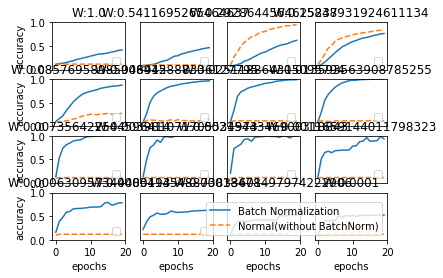

In [27]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

## 正則化

正則化とは特定のデータに囚われない学習モデルを作ること。

### 過学習

過学習とは、訓練データだけに適応しすぎてしまい、訓練データに含まれない他のデータにはうまく対応できない状態を言う。  
過学習が起きる原因としては以下のような原因が挙げられる。  
  
- パラメータを大量に持ち、表現力の高いモデルであること
- 訓練データが少ないこと

#### わざと過学習させる

epoch:0, train acc:0.14666666666666667, test acc:0.1087
epoch:1, train acc:0.17333333333333334, test acc:0.127
epoch:2, train acc:0.21666666666666667, test acc:0.1475
epoch:3, train acc:0.24333333333333335, test acc:0.1669
epoch:4, train acc:0.26, test acc:0.1875
epoch:5, train acc:0.2833333333333333, test acc:0.2045
epoch:6, train acc:0.30666666666666664, test acc:0.2249
epoch:7, train acc:0.34, test acc:0.2411
epoch:8, train acc:0.3466666666666667, test acc:0.2496
epoch:9, train acc:0.36666666666666664, test acc:0.2624
epoch:10, train acc:0.36333333333333334, test acc:0.2681
epoch:11, train acc:0.41, test acc:0.2916
epoch:12, train acc:0.42333333333333334, test acc:0.3005
epoch:13, train acc:0.41333333333333333, test acc:0.3031
epoch:14, train acc:0.44333333333333336, test acc:0.3216
epoch:15, train acc:0.4633333333333333, test acc:0.3298
epoch:16, train acc:0.49333333333333335, test acc:0.3542
epoch:17, train acc:0.49, test acc:0.3539
epoch:18, train acc:0.5466666666666666, test acc

epoch:159, train acc:0.8566666666666667, test acc:0.6952
epoch:160, train acc:0.8633333333333333, test acc:0.6997
epoch:161, train acc:0.8633333333333333, test acc:0.6964
epoch:162, train acc:0.86, test acc:0.6969
epoch:163, train acc:0.86, test acc:0.6923
epoch:164, train acc:0.85, test acc:0.6878
epoch:165, train acc:0.86, test acc:0.6896
epoch:166, train acc:0.8666666666666667, test acc:0.6905
epoch:167, train acc:0.87, test acc:0.686
epoch:168, train acc:0.8566666666666667, test acc:0.6954
epoch:169, train acc:0.8666666666666667, test acc:0.6733
epoch:170, train acc:0.86, test acc:0.6944
epoch:171, train acc:0.8633333333333333, test acc:0.7021
epoch:172, train acc:0.87, test acc:0.6985
epoch:173, train acc:0.87, test acc:0.6966
epoch:174, train acc:0.8733333333333333, test acc:0.7019
epoch:175, train acc:0.8666666666666667, test acc:0.6967
epoch:176, train acc:0.8566666666666667, test acc:0.6941
epoch:177, train acc:0.8666666666666667, test acc:0.6958
epoch:178, train acc:0.87, tes

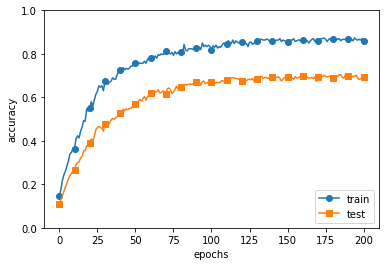

In [29]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

**訓練データに関する認識精度は100%なのに、テストデータに関する認識精度は60%～80%で高止まりしている→過学習状態**